# **<center>Delivery Time Prediction</center>**
### **Problem Statement:**
* **Food Delivery services like Zomato and Swiggy need to show the accurate time it will take to deliver your order to keep transparency with their customers. These companies use Machine Learning algorithms to predict the food delivery time based on how much time the delivery partners took for the same distance in the past.**
* **To predict the food delivery time in real-time, we need to calculate the distance between the food preparation point and the point of food consumption. After finding the distance between the restaurant and the delivery locations, we need to find relationships between the time taken by delivery partners to deliver the food in the past for the same distance.**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
import warnings
import folium

# Filter out warning messages
warnings.filterwarnings("ignore")

# Import specific classes and functions from scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer

# Import the train_test_split function for splitting the dataset
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor



### **1. Data Ingestion**

In [2]:
# Read the CSV file "finalTrain.csv" into a DataFrame named 'df'
df = pd.read_csv("finalTrain.csv")

In [3]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,22:10,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,15:05,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,17:40,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,09:30,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,20:05,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41


### **2. Data Analysis (EDA)** 

In [4]:
# Display the number of rows and columns in the DataFrame
print("=============================================================================")
print("Shape of DataFrame:", df.shape)
print("=============================================================================")

# Display the column names of the DataFrame
print("Columns in DataFrame:", df.columns)
print("=============================================================================")

# Display information about the DataFrame including data types and non-null counts
print("Info about DataFrame:")
print(df.info())
print("=============================================================================")

# Display the count of missing values in each column of the DataFrame
print("Count of Missing Values in Each Column:")
print(df.isnull().sum())
print("=============================================================================")

# Display the summary statistics of the DataFrame, transposed for better readability
print("Summary Statistics:")
df.describe().T


Shape of DataFrame: (45584, 20)
Columns in DataFrame: Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weather_conditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken (min)'],
      dtype='object')
Info about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45584 entries, 0 to 45583
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45584 non-null  object 
 1   Delivery_person_ID           45584 non-null  object 
 2   Delivery_person_Age          43730 non-null  float64
 3   Delivery_person_Ratings      43676 non-null  f

,count,mean,std,min,25%,50%,75%,max
Delivery_person_Age,43730.0,29.566911,5.815064,15.000000,25.000000,30.000000,35.000000,50.000000
Delivery_person_Ratings,43676.0,4.633774,0.334744,1.000000,4.500000,4.700000,4.900000,6.000000
Restaurant_latitude,45584.0,17.017948,8.185674,-30.905562,12.933284,18.551440,22.728163,30.914057
Restaurant_longitude,45584.0,70.229684,22.885575,-88.366217,73.170000,75.897963,78.044095,88.433452
Delivery_location_latitude,45584.0,17.465480,7.335562,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45584.0,70.844161,21.120578,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45584.0,1.023385,0.839055,0.000000,0.000000,1.000000,2.000000,3.000000
multiple_deliveries,44591.0,0.744635,0.572510,0.000000,0.000000,1.000000,1.000000,3.000000
Time_taken (min),45584.0,26.293963,9.384298,10.000000,19.000000,26.000000,32.000000,54.000000


**Observation:**
1. We have missing values in 9 columns. Need to impute the missing values

In [5]:
# Loop through each column in the DataFrame
for i in df.columns:
    # Print the number of unique values in the current column
    print(f"Number of unique values in {i} is: {df[i].nunique()}")
    print("#######################################################")
    
    # Check if the number of unique values is less than 8
    if (df[i].nunique()) < 8:
        # Print the unique values if there are less than 8 unique values
        print(f"Unique values are: {df[i].unique()}")
        print("***************************************************")
    else:
        # If there are more than 8 unique values, skip printing
        pass


Number of unique values in ID is: 45584
#######################################################
Number of unique values in Delivery_person_ID is: 1320
#######################################################
Number of unique values in Delivery_person_Age is: 22
#######################################################
Number of unique values in Delivery_person_Ratings is: 28
#######################################################
Number of unique values in Restaurant_latitude is: 657
#######################################################
Number of unique values in Restaurant_longitude is: 518
#######################################################
Number of unique values in Delivery_location_latitude is: 4373
#######################################################
Number of unique values in Delivery_location_longitude is: 4373
#######################################################
Number of unique values in Order_Date is: 44
#######################################################
Number

Unique values are: ['Snack' 'Meal' 'Drinks' 'Buffet']
***************************************************
Number of unique values in Type_of_vehicle is: 4
#######################################################
Unique values are: ['motorcycle' 'scooter' 'electric_scooter' 'bicycle']
***************************************************
Number of unique values in multiple_deliveries is: 4
#######################################################
Unique values are: [ 3.  1.  0. nan  2.]
***************************************************
Number of unique values in Festival is: 2
#######################################################
Unique values are: ['No' 'Yes' nan]
***************************************************
Number of unique values in City is: 3
#######################################################
Unique values are: ['Metropolitian' 'Urban' 'Semi-Urban' nan]
***************************************************
Number of unique values in Time_taken (min) is: 45
#################

In [6]:

# Initialize lists to store feature-related information
feature = []
dtypes = []
count = []
unique = []
missing = []
missing_percentage=[]

# Iterate through each column in the DataFrame
for column in df.columns:
    # Store the column name in the 'feature' list
    feature.append(column)
    # Store the total number of entries in the column in the 'count' list
    count.append(len(df[column]))
    # Store the number of missing values in the column in the 'missing' list
    missing.append(df[column].isnull().sum())
    # Store the number of unique values in the column in the 'unique' list
    unique.append(df[column].nunique())
    # Calculate the percentage of missing values in the column and store it in the 'missing_percentage' list
    missing_percentage.append((df[column].isnull().sum() / df.shape[0]) * 100)
    # Store the data type of the column in the 'dtypes' list
    dtypes.append(df[column].dtypes)

# Create a DataFrame using the collected information
dataframe=pd.DataFrame({
            'feature':feature,
            'count':count,
            'missing':missing,
            'nunique':unique,
            'missing_percentage':missing_percentage,
            'dtypes':dtypes
             }) 

# Set the 'feature' column as the index of the DataFrame
dataframe.set_index('feature', inplace=True)
# Print the created DataFrame
dataframe


,count,missing,nunique,missing_percentage,dtypes
feature,,,,,
ID,45584,0,45584,0.000000,object
Delivery_person_ID,45584,0,1320,0.000000,object
Delivery_person_Age,45584,1854,22,4.067217,float64
Delivery_person_Ratings,45584,1908,28,4.185679,float64
Restaurant_latitude,45584,0,657,0.000000,float64
Restaurant_longitude,45584,0,518,0.000000,float64
Delivery_location_latitude,45584,0,4373,0.000000,float64
Delivery_location_longitude,45584,0,4373,0.000000,float64
Order_Date,45584,0,44,0.000000,object


**Handling "Time_Orderd" column**

In [7]:
# Drop the 'ID' column as it is not important
df.drop('ID', axis=1, inplace=True)
# Convert 'Order_Date' column to datetime format and reformat it to 'YYYY-MM-DD'
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')

# Extract year, month, and day from the 'Order_Date' column
df['year'] = pd.to_datetime(df['Order_Date']).dt.year
df['month'] = pd.to_datetime(df['Order_Date']).dt.month
df['day'] = pd.to_datetime(df['Order_Date']).dt.day

# Drop the 'Order_Date' column as it is no longer needed
df.drop('Order_Date', axis=1, inplace=True)

# Check for null values in the DataFrame
print(f"Null values count before removal ('Time_Orderd' column): {df['Time_Orderd'].isnull().sum()}")
# Remove rows with NULL values in the 'Time_Orderd' column
df.dropna(subset=['Time_Orderd'], inplace=True)
# Check for null values in the DataFrame
print(f"Null values count after removal ('Time_Orderd' column): {df['Time_Orderd'].isnull().sum()}")

# Replace '.' with ':' in the 'Time_Orderd' column
df['Time_Orderd'] = df['Time_Orderd'].str.replace('.', ':')

# Define a lambda function with error handling
def extract_time(x):
    try:
        return x.split(':')[0] + ':' + x.split(':')[1][:2]  # Extract hours and first two characters of minutes
    except IndexError:
        return '00:00'  # Handle the case where the format is incorrect

# Apply the lambda function to the Order_Time column
df['Time_Orderd'] = df['Time_Orderd'].apply(extract_time)  # Apply the function to extract time

# Convert the Order_Time column to a time data type
df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd'], format='%H:%M:%S', errors='ignore')

# Extract the hour from the Time_Orderd column and create a new column
df['TimeOrder_Hour'] = df['Time_Orderd'].str.split(':', expand=True)[0]  # Split the time to get hours

# Replace '0' with '00' to indicate 24th hour
df['TimeOrder_Hour'] = df['TimeOrder_Hour'].replace('0', '00')  # Correct '0' to '00'

# Change the datatype of TimeOrder_Hour column to integer
df['TimeOrder_Hour'] = df['TimeOrder_Hour'].astype('int32')  # Convert to integer

# Extract the minutes from the Time_Orderd column and create a new column
df['TimeOrder_min'] = df['Time_Orderd'].str.split(':', expand=True)[1]  # Split the time to get minutes

# Change the datatype of TimeOrder_min column to integer
df['TimeOrder_min'] = df['TimeOrder_min'].astype('int32')  # Convert to integer



Null values count before removal ('Time_Orderd' column): 1731
Null values count after removal ('Time_Orderd' column): 0


* In ouir TimeOrder_Hour columns
* 7AM -12PM - breakfash
* 12PM -15 PM - lunch
* 15PM-17 PM- after lunch
* 17-19 -  evening snaks
* 19-24 - Dinner

**Handling "Time_Order_picked" column**

In [8]:
# Replace any dots with colons in the 'Time_Order_picked' column
df['Time_Order_picked'] = df['Time_Order_picked'].str.replace('.', ':')

# Apply the lambda function to the 'Time_Order_picked' column
df['Time_Order_picked'] = df['Time_Order_picked'].apply(extract_time)

# Convert the 'Time_Order_picked' column to a time data type
df['Time_Order_picked'] = pd.to_datetime(df['Time_Order_picked'], format='%H:%M:%S', errors='ignore')

# Extract and convert the hour part of the 'Time_Order_picked' column
df['Time_Order_picked_Hour'] = df['Time_Order_picked'].str.split(':', expand=True)[0]
df['Time_Order_picked_Hour'] = df['Time_Order_picked_Hour'].astype('int32')

# Extract and convert the minute part of the 'Time_Order_picked' column
df['Time_Order_picked_min'] = df['Time_Order_picked'].str.split(':', expand=True)[1]
df['Time_Order_picked_min'] = df['Time_Order_picked_min'].astype('int32')


In [9]:
df.head()

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weather_conditions,...,Festival,City,Time_taken (min),year,month,day,TimeOrder_Hour,TimeOrder_min,Time_Order_picked_Hour,Time_Order_picked_min
0,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,21:55,22:10,Fog,...,No,Metropolitian,46,2022,2,12,21,55,22,10
1,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,14:55,15:05,Stormy,...,No,Metropolitian,23,2022,2,13,14,55,15,5
2,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,17:30,17:40,Sandstorms,...,No,Metropolitian,21,2022,3,4,17,30,17,40
3,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,09:20,09:30,Sandstorms,...,No,Metropolitian,20,2022,2,13,9,20,9,30
4,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,19:50,20:05,Fog,...,No,Metropolitian,41,2022,2,14,19,50,20,5


**Extraction of city from "Delivery_person_ID" columns**

In [10]:
# Spilliting the Delivery_person_id on the bases of "RES", this will give us the city name of delivery
# Using the split() function to separate the Delivery_person_ID using "RES" as a delimiter
# The expand=True argument ensures that the result is returned as a DataFrame
# The [0] index selects the first part of the split result, which represents the city name
df['Delivery_city'] = df['Delivery_person_ID'].str.split('RES', expand=True)[0]


**Imputation of null value in "Delivery_person_Ratings" column with the mean of that "Delivery_person_ID"**

In [11]:
# Calculate the mean ratings for each Delivery_person_ID and round them to 1 decimal place
rating_map = round(df.groupby('Delivery_person_ID')['Delivery_person_Ratings'].mean(), 1).to_dict()

print(f"Null values count before removal ('Delivery_person_Ratings' column): {df['Delivery_person_Ratings'].isnull().sum()}")
# Fill in missing values in 'Delivery_person_Ratings' column using the mapped mean values based on 'Delivery_person_ID'
df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].fillna(df['Delivery_person_ID'].map(rating_map))
print(f"Null values count after removal ('Delivery_person_Ratings' column): {df['Delivery_person_Ratings'].isnull().sum()}")

# Explanation:
# This code calculates the mean ratings for each unique 'Delivery_person_ID' in the DataFrame 'df'.
# The 'rating_map' is a dictionary that holds the mean ratings for each delivery person.
# Then, it fills the missing values in the 'Delivery_person_Ratings' column by mapping the mean ratings using 'Delivery_person_ID'.
# This technique helps to impute missing ratings based on the average ratings of the respective delivery person.


Null values count before removal ('Delivery_person_Ratings' column): 268
Null values count after removal ('Delivery_person_Ratings' column): 0


working with map

In [12]:
# folium.Map(tiles="cartodb positron")
df.columns

Index(['Delivery_person_ID', 'Delivery_person_Age', 'Delivery_person_Ratings',
       'Restaurant_latitude', 'Restaurant_longitude',
       'Delivery_location_latitude', 'Delivery_location_longitude',
       'Time_Orderd', 'Time_Order_picked', 'Weather_conditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_order',
       'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
       'Time_taken (min)', 'year', 'month', 'day', 'TimeOrder_Hour',
       'TimeOrder_min', 'Time_Order_picked_Hour', 'Time_Order_picked_min',
       'Delivery_city'],
      dtype='object')

**Handling of "Restaurant_latitude", "Restaurant_longitude", "Delivery_location_latitude" and "Delivery_location_longitude" columns**

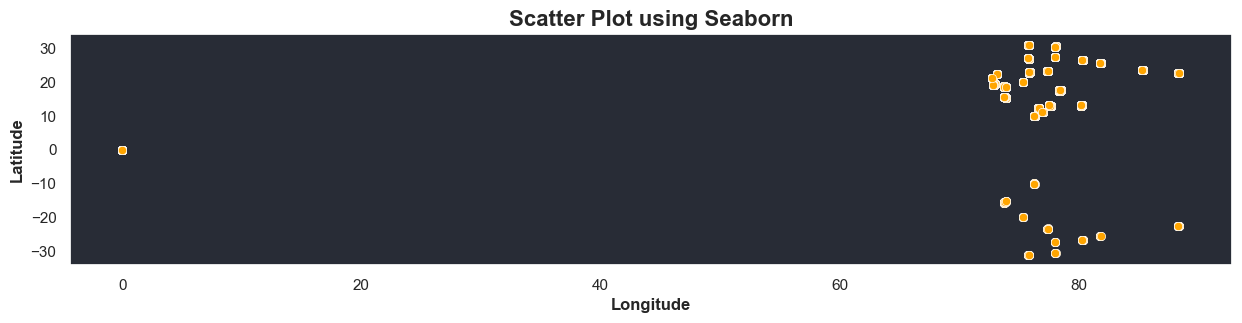

In [13]:
from matplotlib.font_manager import FontProperties
data1 = df.copy()
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a scatter plot using Seaborn with different dot colors
plt.figure(figsize=(15, 3))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the plot
plot = sns.scatterplot(x="Restaurant_longitude", y="Restaurant_latitude", data=data1, color='orange')
plot.set_title('Scatter Plot using Seaborn', fontproperties=font_title)
plot.set_xlabel('Longitude', fontproperties=font_bold)
plot.set_ylabel('Latitude', fontproperties=font_bold)

plt.show()

**Observations:**
* India's latitude extends from 8°4 N to 37°6 North.
* India's longitude spans from 68°7 E to 97°25 East.
* The dataset pertains to India. While some latitudes are given as negative (-), it's worth noting that negative latitudes are associated with the Indian Ocean. Hence, it's possible that the negative sign in latitudes could be due to an error.

In [14]:
# Changing negative values to positive in the dataset
"""
abs() function returns the absolute value. The absolute
value of any number is always positive; it removes the negative sign of a number in Python.
"""
df['Restaurant_latitude'] = df['Restaurant_latitude'].abs()

import math
# To calculate the distance between two points on a sphere (such as the Earth), we can use the Haversine formula
def distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula to calculate distance
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    R = 6371.0 # Earth's radius in km
    dist = R * c
    
    return dist

# Calculate distance between coordinates and add a new column 'distance'
# Assuming df is your DataFrame
df['distance'] = df.apply(lambda row: distance(row['Restaurant_latitude'], row['Restaurant_longitude'], row['Delivery_location_latitude'], row['Delivery_location_longitude']), axis=1)

# Calculate the mean distance for groups of coordinates
print("===========================================================================")
print("Mean distance for groups of coordinates")
print(df.groupby(['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude'])['distance'].mean())
print("===========================================================================")
# Filter out records with incorrect latitude values
# Droping those lattitude and longitude which are less than and above to latitude of india is 8°4` N  to 37°6` North longitude of india is 68°7` E to 97°25` East
df = df.drop(df[(df['Restaurant_latitude'] < 8) & (df['Delivery_location_latitude'] < 8)].index)

# Check records with latitude values that seem incorrect
print(df[(df['Restaurant_latitude'] > 37) & (df['Delivery_location_latitude'] > 37)])
print("===========================================================================")
print(df[(df['Restaurant_longitude'] < 68) & (df['Delivery_location_longitude'] < 68)])
print("===========================================================================")



Mean distance for groups of coordinates
Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  Delivery_location_longitude
0.000000             0.00000               0.010000                    0.01000                         1.572534
                                           0.020000                    0.02000                         3.145067
                                           0.030000                    0.03000                         4.717601
                                           0.040000                    0.04000                         6.290135
                                           0.050000                    0.05000                         7.862668
                                                                                                        ...    
30.914057            75.83982              30.994057                   75.91982                       11.718720
                                           31.004057                   75.929

**Minimum distance**

In [15]:
# Calculate the minimum distance by grouping the DataFrame by 'distance' column and selecting specific columns
# Then, find the minimum values for the latitude and longitude columns within each 'distance' group
min_distance = df.groupby('distance')[['Restaurant_latitude', 'Restaurant_longitude','Delivery_location_latitude', 'Delivery_location_longitude']].min().sort_values(by='distance', ascending=True).head(1)
# Print the DataFrame containing the minimum distance information
min_distance


,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude
distance,,,,
1.465067,30.914057,75.83982,30.924057,75.84982


In [16]:
import folium
from branca.element import Figure
fig2=Figure(width = 1200,height = 400)

# Create a map object centered on a specific location
m = folium.Map(location=[30.914057, 75.83982], zoom_start=12)

# Add a marker for the restaurant location
folium.Marker(location=[30.914057, 75.83982], popup="Restaurant",icon=folium.Icon(color='purple',prefix='fa',icon='anchor')).add_to(m)

# Add a marker for the delivery location
folium.Marker(location=[30.924057, 75.84982], popup="Delivery").add_to(m)

# Draw a line between the two locations
folium.PolyLine(locations=[[30.914057, 75.83982], [30.924057, 75.84982]], color='red').add_to(m)

# Display the map

fig2.add_child(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('Stamen Water Color').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('cartodbdark_matter').add_to(m)
folium.LayerControl().add_to(m)
m

**Maximum distance**

In [17]:

# Calculate the maximum distance by grouping the DataFrame by 'distance' column and selecting specific columns
# Then, find the maximum values for the latitude and longitude columns within each 'distance' group
max_distance = df.groupby('distance')[['Restaurant_latitude', 'Restaurant_longitude','Delivery_location_latitude', 'Delivery_location_longitude']].max().sort_values(by='distance', ascending=False).head(1)
# Print the DataFrame containing the maximum distance information
max_distance


,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude
distance,,,,
20.969489,25.443994,81.860187,25.583994,82.000187


In [18]:
tooltips=f"Distance: {df['distance'].max()} km"
import folium
from branca.element import Figure
fig2=Figure(width = 1200,height = 400)

# Create a map object centered on a specific location
m = folium.Map(location=[25.443994, 81.860187], zoom_start=12)

# Add a marker for the restaurant location
folium.Marker(location=[25.443994, 81.860187], popup="Restaurant",icon=folium.Icon(color='purple',prefix='fa',icon='anchor')).add_to(m)

# Add a marker for the delivery location
folium.Marker(location=[25.583994, 82.000187], popup="Delivery").add_to(m)

# Draw a line between the two locations
folium.PolyLine(locations=[[25.443994, 81.860187], [25.583994,82.000187]], color='red',tooltip=tooltips).add_to(m)

# Display the map

fig2.add_child(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('Stamen Water Color').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('cartodbdark_matter').add_to(m)
folium.LayerControl().add_to(m)
m

##### **Univariate Analysis**

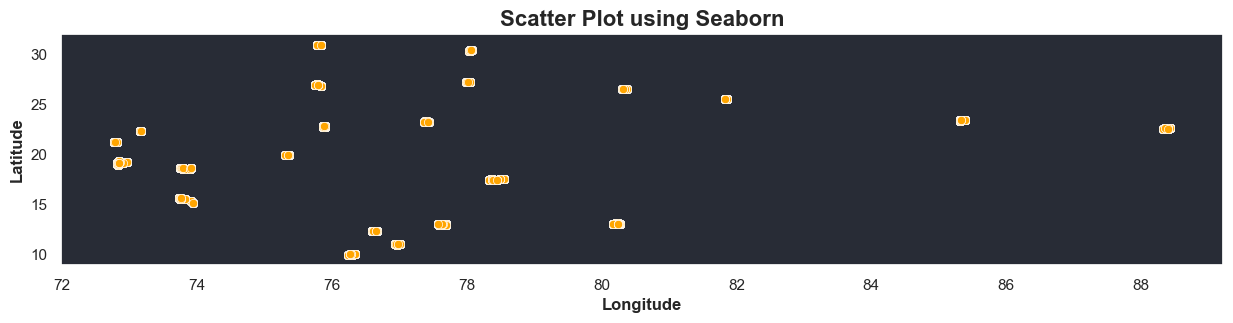

In [19]:
# plotting the lattitude and loggitude
data1 = df.copy()

# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a scatter plot using Seaborn with different dot colors
plt.figure(figsize=(15, 3))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the plot
plot = sns.scatterplot(x="Restaurant_longitude", y="Restaurant_latitude", data=data1, color='orange')
plot.set_title('Scatter Plot using Seaborn', fontproperties=font_title)
plot.set_xlabel('Longitude', fontproperties=font_bold)
plot.set_ylabel('Latitude', fontproperties=font_bold)

plt.show()

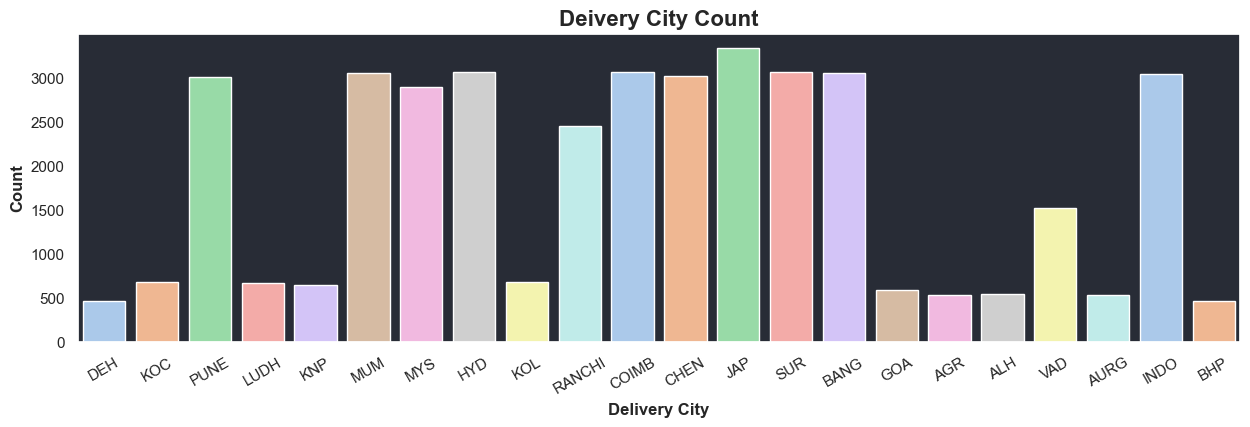

In [20]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create the plot using Seaborn with the same style
plt.figure(figsize=(15, 4))
# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
# Create font properties instances for bold text
font_title = FontProperties(size=16, weight="bold")

# Create the count plot
plot = sns.countplot(x='Delivery_city', data=data1, palette='pastel')
plot.set_title('Deivery City Count', fontproperties=font_title)
plot.set_xlabel('Delivery City', fontproperties = font_bold)
plot.set_ylabel('Count', fontproperties = font_bold)

# Rotate x-axis labels vertically for better readability
plot.set_xticklabels(plot.get_xticklabels(), rotation = 30)

plt.show()


**Observations:**
1. Cities like -  PUNE, MUM, MYS, HYD , CHEN, BANG, INDO, RANCHI have more no. of food ordered.

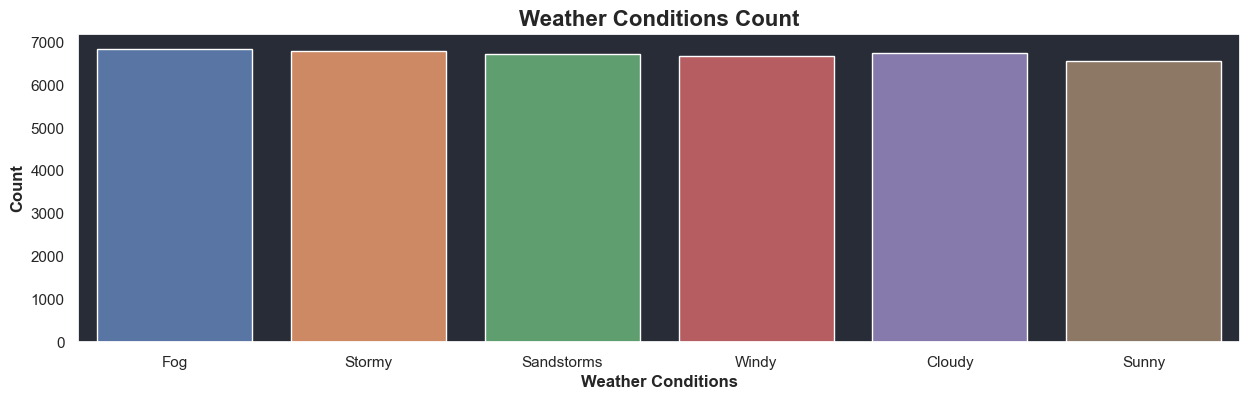

In [21]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a count plot using Seaborn
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the count plot
plot = sns.countplot(x="Weather_conditions", data=data1)
plot.set_title('Weather Conditions Count', fontproperties=font_title)
plot.set_xlabel('Weather Conditions', fontproperties=font_bold)
plot.set_ylabel('Count', fontproperties=font_bold)
plot.set_xticklabels(plot.get_xticklabels(), rotation='horizontal')

plt.show()

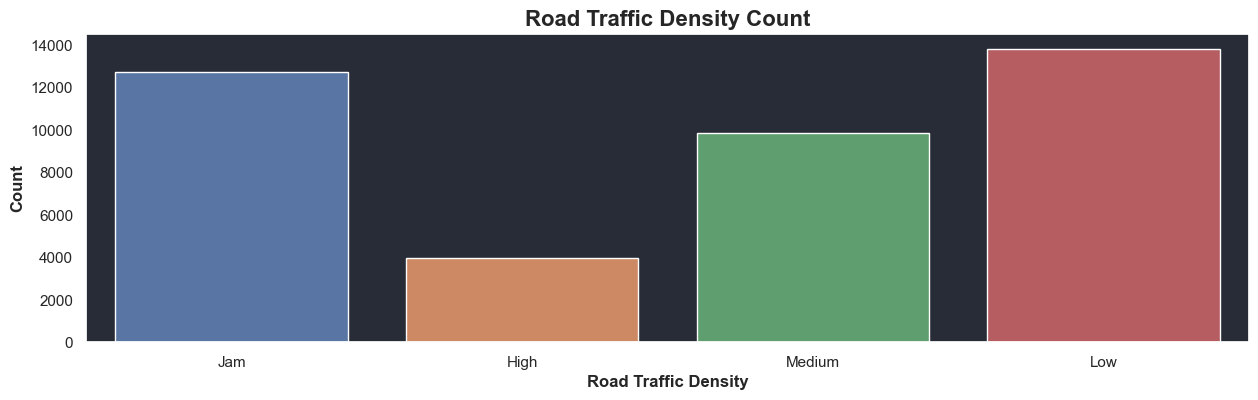

In [22]:

# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create the plot using Seaborn with the same style
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the count plot using Seaborn
plot = sns.countplot(x='Road_traffic_density', data=data1)
plot.set_title('Road Traffic Density Count', fontproperties=font_title)
plot.set_xlabel('Road Traffic Density', fontproperties=font_bold)
plot.set_ylabel('Count', fontproperties=font_bold)
plot.set_xticklabels(plot.get_xticklabels(), rotation='horizontal')

plt.show()

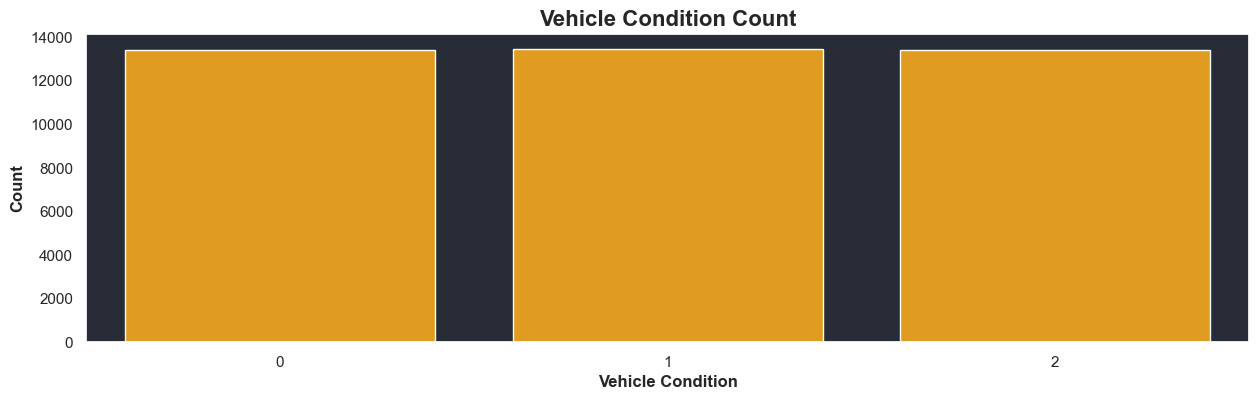

In [23]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a bar plot using Seaborn
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the plot
plot = sns.countplot(x="Vehicle_condition", data=data1, palette=["orange"])
plot.set_title('Vehicle Condition Count', fontproperties=font_title)
plot.set_xlabel('Vehicle Condition', fontproperties=font_bold)
plot.set_ylabel('Count', fontproperties=font_bold)

plt.show()

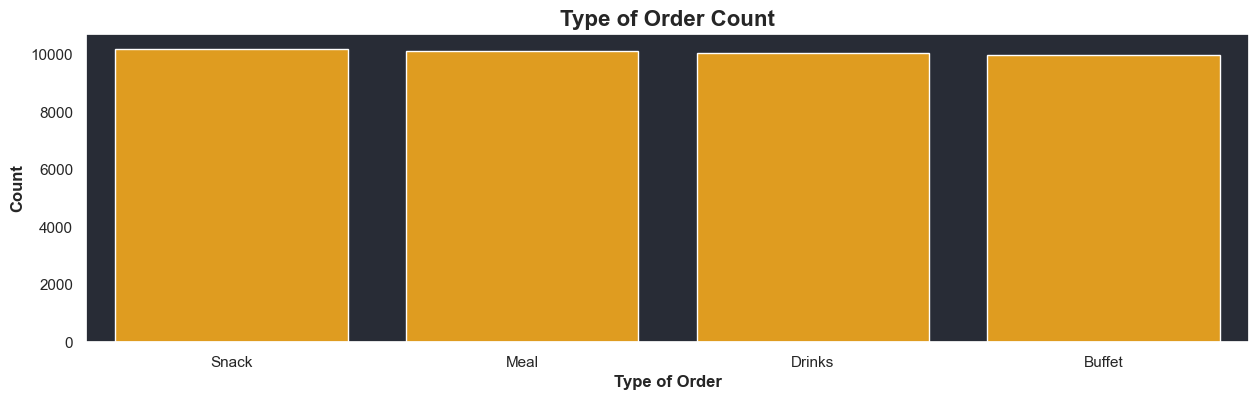

In [24]:

# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a count plot using Seaborn
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the plot
plot = sns.countplot(x="Type_of_order", data=data1, palette=["orange"])
plot.set_title('Type of Order Count', fontproperties=font_title)
plot.set_xlabel('Type of Order', fontproperties=font_bold)
plot.set_ylabel('Count', fontproperties=font_bold)
plt.xticks(rotation='horizontal')

plt.show()

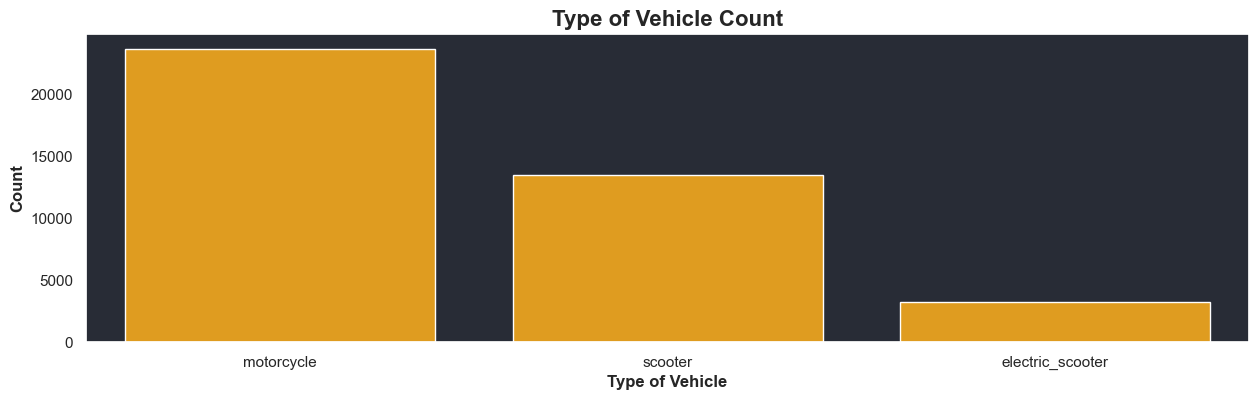

In [25]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a count plot using Seaborn
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the plot
plot = sns.countplot(x="Type_of_vehicle", data=data1, palette=["orange"])
plot.set_title('Type of Vehicle Count', fontproperties=font_title)
plot.set_xlabel('Type of Vehicle', fontproperties=font_bold)
plot.set_ylabel('Count', fontproperties=font_bold)
plt.xticks(rotation='horizontal')

plt.show()

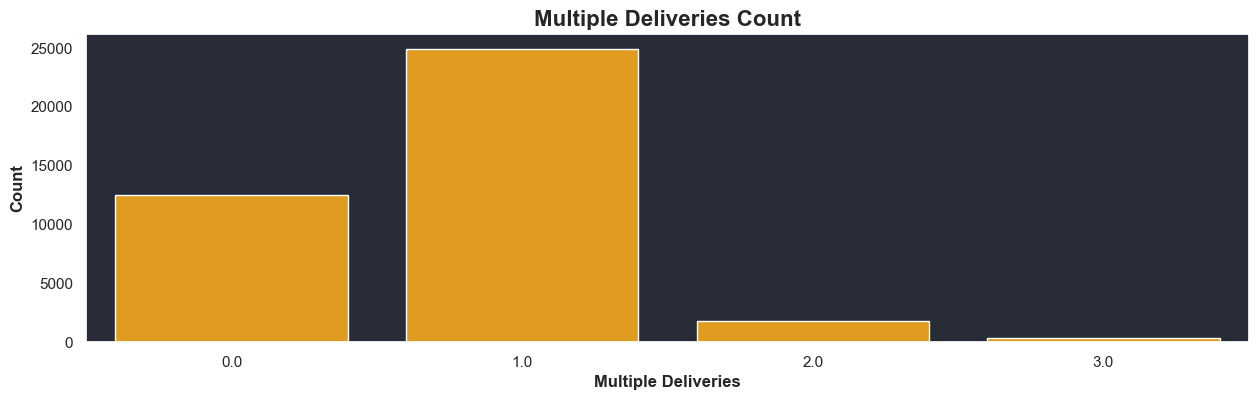

In [26]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a count plot using Seaborn
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the plot
plot = sns.countplot(x="multiple_deliveries", data=data1, palette=["orange"])
plot.set_title('Multiple Deliveries Count', fontproperties=font_title)
plot.set_xlabel('Multiple Deliveries', fontproperties=font_bold)
plot.set_ylabel('Count', fontproperties=font_bold)
plt.xticks(rotation='horizontal')

plt.show()

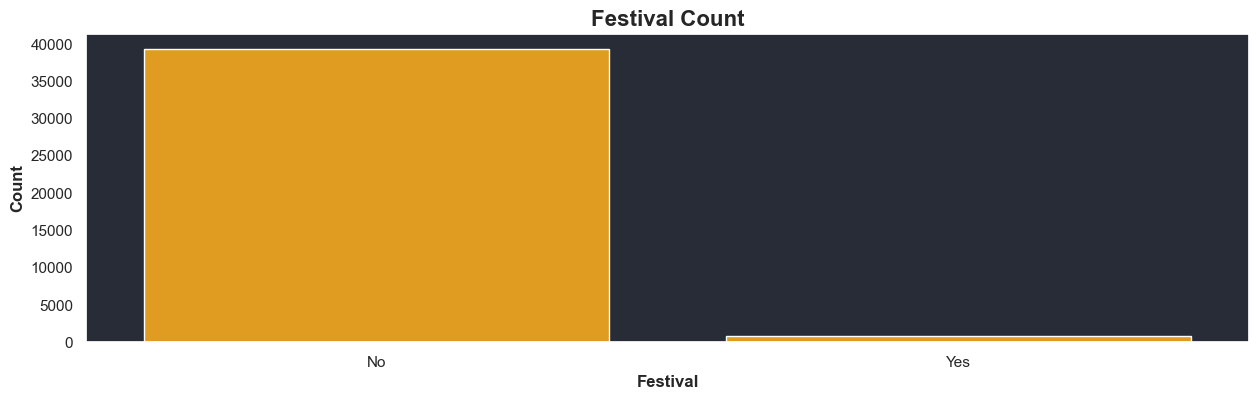

In [27]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a count plot using Seaborn
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the plot
plot = sns.countplot(x="Festival", data=data1, palette=["orange"])
plot.set_title('Festival Count', fontproperties=font_title)
plot.set_xlabel('Festival', fontproperties=font_bold)
plot.set_ylabel('Count', fontproperties=font_bold)
plt.xticks(rotation='horizontal')

plt.show()

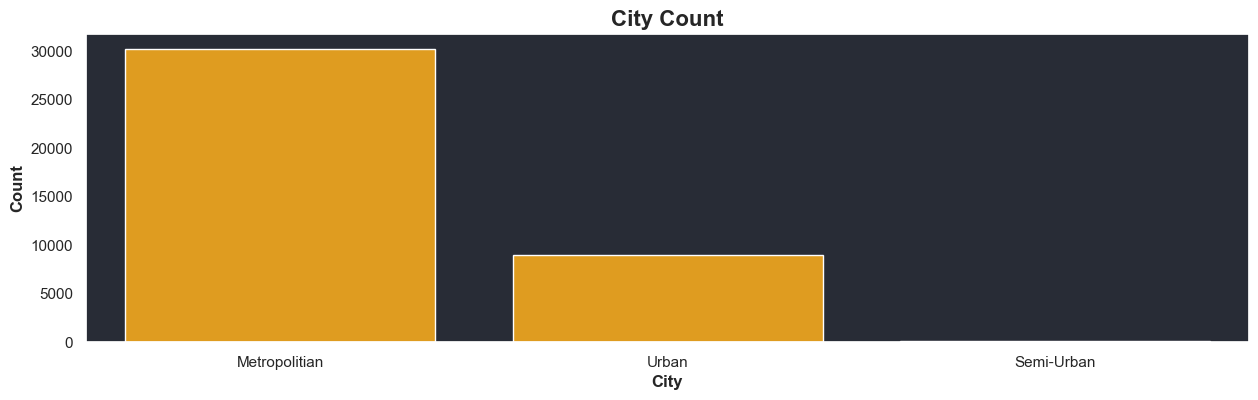

In [28]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a count plot using Seaborn
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the plot
plot = sns.countplot(x="City", data=data1, palette=["orange"])
plot.set_title('City Count', fontproperties=font_title)
plot.set_xlabel('City', fontproperties=font_bold)
plot.set_ylabel('Count', fontproperties=font_bold)
plt.xticks(rotation='horizontal')

plt.show()

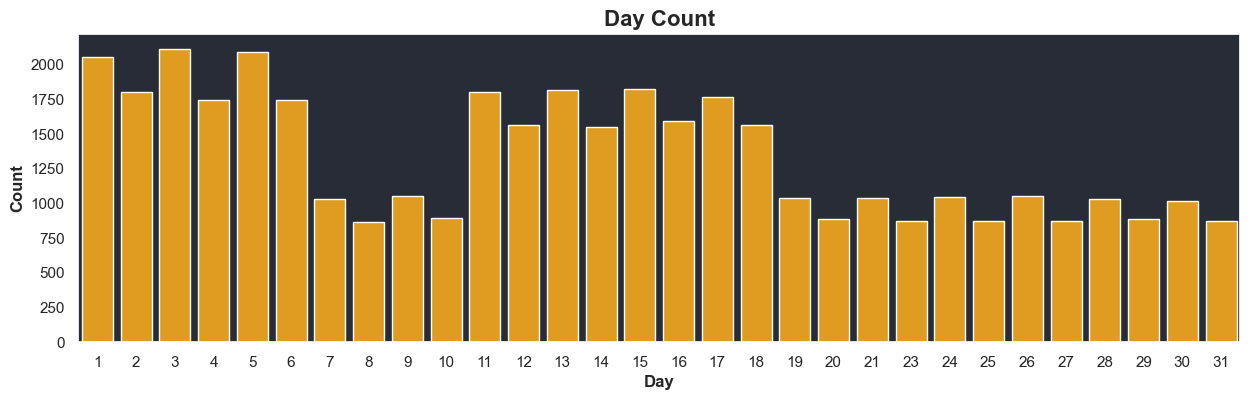

In [29]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a count plot using Seaborn
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the plot
plot = sns.countplot(x="day", data=data1, palette=["orange"])
plot.set_title('Day Count', fontproperties=font_title)
plot.set_xlabel('Day', fontproperties=font_bold)
plot.set_ylabel('Count', fontproperties=font_bold)
plt.xticks(rotation='horizontal')

plt.show()

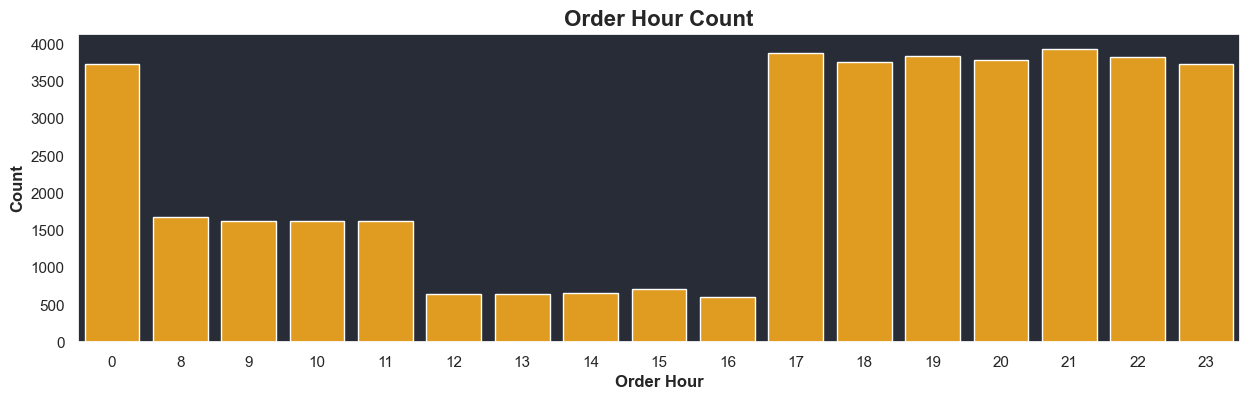

In [30]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a count plot using Seaborn
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the plot
plot = sns.countplot(x="TimeOrder_Hour", data=data1, palette=["orange"])
plot.set_title('Order Hour Count', fontproperties=font_title)
plot.set_xlabel('Order Hour', fontproperties=font_bold)
plot.set_ylabel('Count', fontproperties=font_bold)
plt.xticks(rotation='horizontal')

plt.show()

**Observations:**
1. More no. of order is b/w 8 - 11 am and evening 5 to night 12 people more ofter deliver food in the evening and morning time

##### **Bi-Variate Analysis**

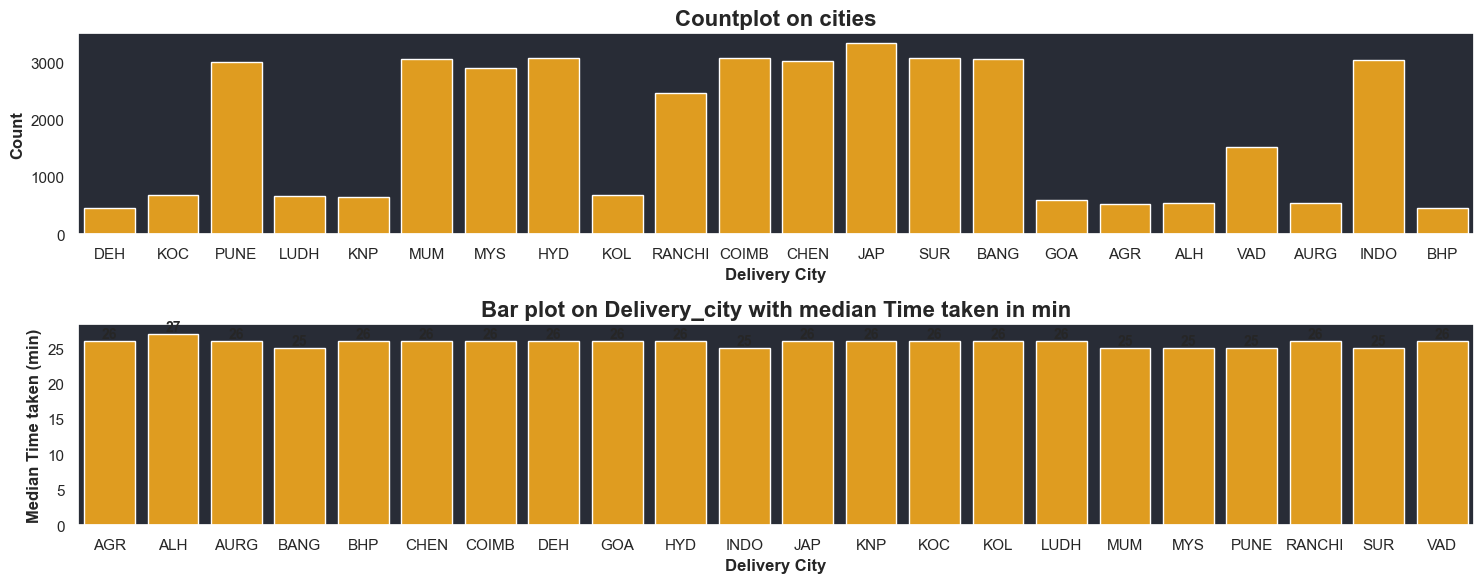

In [31]:

df['Time_taken (min)'] = pd.to_numeric(df['Time_taken (min)'], errors='coerce')

# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a figure with two subplots arranged in rows
plt.figure(figsize=(15, 6))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Subplot 1: Countplot of Delivery_city
plt.subplot(2, 1, 1)  # First row, first column
sns.countplot(x="Delivery_city", data=df, palette=["orange"])
plt.title("Countplot on cities", fontproperties=font_title)
plt.xlabel('Delivery City', fontproperties=font_bold)
plt.ylabel('Count', fontproperties=font_bold)

# Subplot 2: Bar plot of median Time_taken (min) w.r.t Delivery_city
plt.subplot(2, 1, 2)  # Second row, first column
data1 = df.groupby(['Delivery_city'])['Time_taken (min)'].median().reset_index()
ax = sns.barplot(x='Delivery_city', y='Time_taken (min)', data=data1, errwidth=0, palette=["orange"])
plt.title('Bar plot on Delivery_city with median Time taken in min', fontproperties=font_title)
plt.xlabel('Delivery City', fontproperties=font_bold)
plt.ylabel('Median Time taken (min)', fontproperties=font_bold)

# Add labels to the bar plot
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, fontproperties=font_bold)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


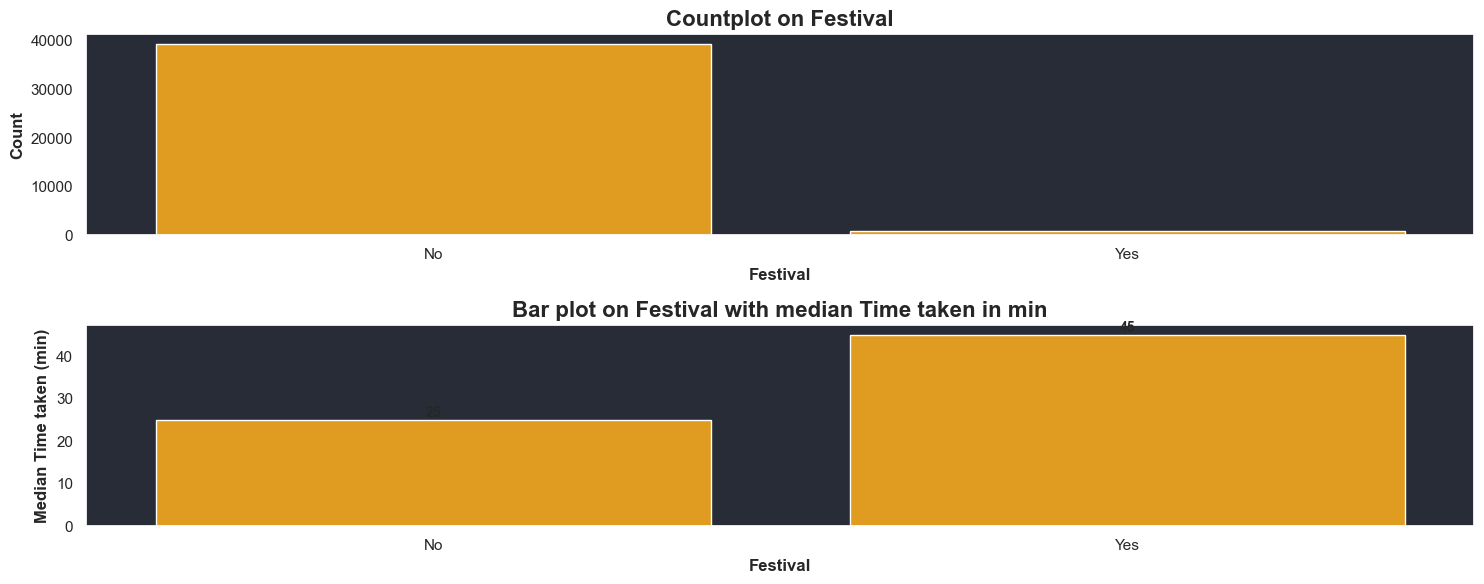

In [32]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a figure with two subplots arranged in rows
plt.figure(figsize=(15, 6))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Subplot 1: Countplot of Festival
plt.subplot(2, 1, 1)  # First row, first column
sns.countplot(x="Festival", data=df, palette=["orange"])
plt.title("Countplot on Festival", fontproperties=font_title)
plt.xlabel('Festival', fontproperties=font_bold)
plt.ylabel('Count', fontproperties=font_bold)

# Subplot 2: Bar plot of median Time_taken (min) w.r.t Festival
plt.subplot(2, 1, 2)  # Second row, first column
data1 = df.groupby(['Festival'])['Time_taken (min)'].median().reset_index()
ax = sns.barplot(x='Festival', y='Time_taken (min)', data=data1, errwidth=0, palette=["orange"])
plt.title('Bar plot on Festival with median Time taken in min', fontproperties=font_title)
plt.xlabel('Festival', fontproperties=font_bold)
plt.ylabel('Median Time taken (min)', fontproperties=font_bold)

# Add labels to the bar plot
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, fontproperties=font_bold)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

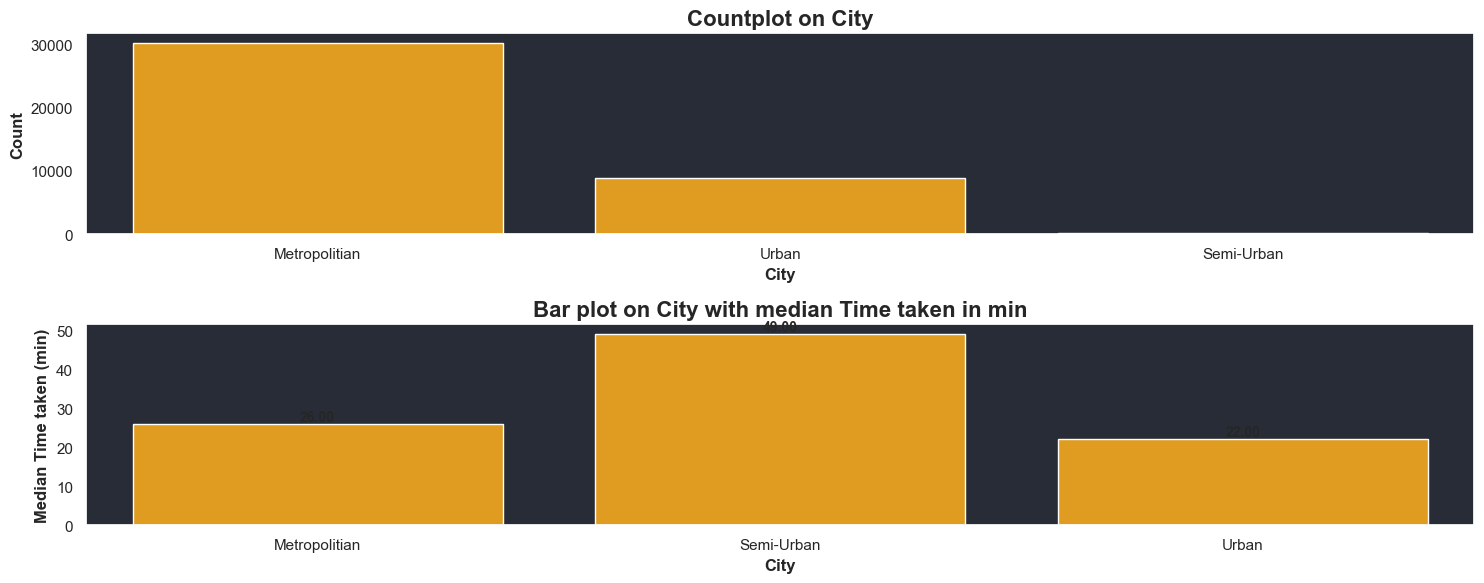

In [33]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a figure with subplots arranged in a row
plt.figure(figsize=(15, 6))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Subplot 1: Countplot of City
plt.subplot(2, 1, 1)
sns.countplot(x="City", data=df, palette=["orange"])
plt.title("Countplot on City", fontproperties=font_title)
plt.xlabel('City', fontproperties=font_bold)
plt.ylabel('Count', fontproperties=font_bold)

# Subplot 2: Bar plot of median Time_taken (min) w.r.t City
plt.subplot(2, 1, 2)
data1 = df.groupby(['City'])['Time_taken (min)'].median().reset_index()
ax = sns.barplot(x='City', y='Time_taken (min)', data=data1, errwidth=0, palette=["orange"])
plt.title('Bar plot on City with median Time taken in min', fontproperties=font_title)
plt.xlabel('City', fontproperties=font_bold)
plt.ylabel('Median Time taken (min)', fontproperties=font_bold)

# Add labels to the bar plot
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                ha='center', va='center', size=10, fontproperties=font_bold,
                xytext=(0, 5), textcoords='offset points')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

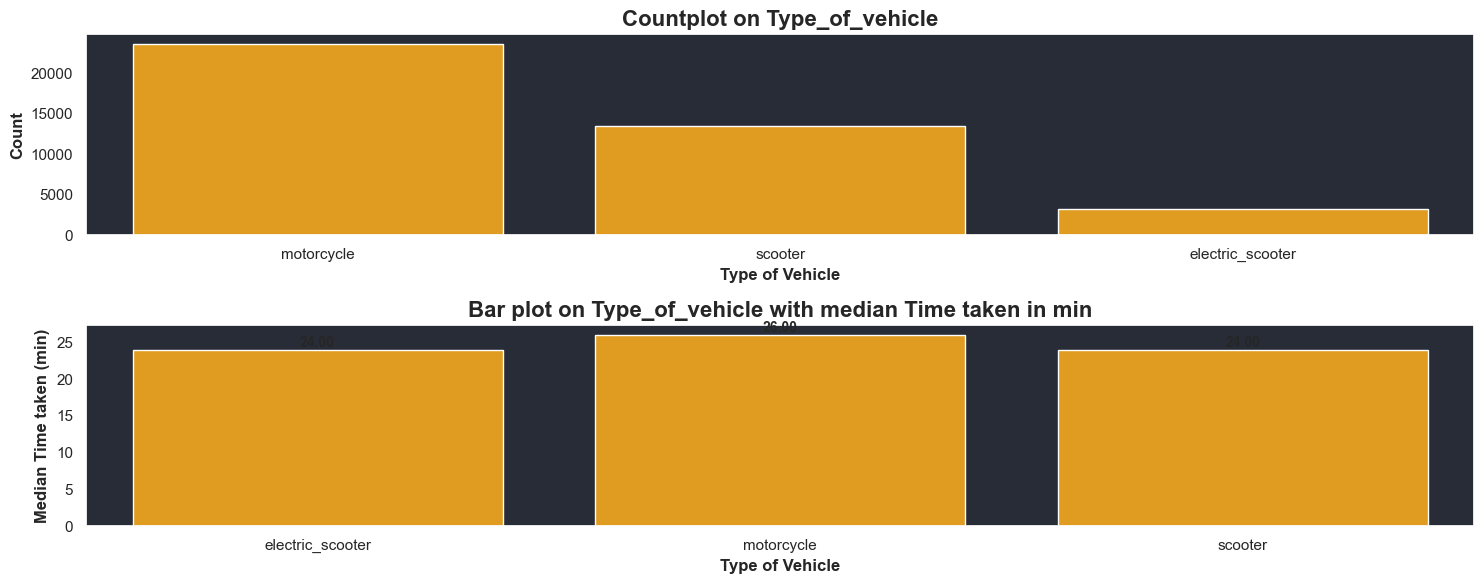

In [34]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a figure with subplots arranged in a row
plt.figure(figsize=(15, 6))

# Subplot 1: Countplot of Type_of_vehicle
plt.subplot(2, 1, 1)
sns.countplot(x="Type_of_vehicle", data=df, palette=["orange"])
plt.title("Countplot on Type_of_vehicle", fontproperties=font_title)
plt.xlabel('Type of Vehicle', fontproperties=font_bold)
plt.ylabel('Count', fontproperties=font_bold)

# Subplot 2: Bar plot of median Time_taken (min) w.r.t Type_of_vehicle
plt.subplot(2, 1, 2)
data2 = df.groupby(['Type_of_vehicle'])['Time_taken (min)'].median().reset_index()
ax2 = sns.barplot(x='Type_of_vehicle', y='Time_taken (min)', data=data2, errwidth=0, palette=["orange"])
plt.title('Bar plot on Type_of_vehicle with median Time taken in min', fontproperties=font_title)
plt.xlabel('Type of Vehicle', fontproperties=font_bold)
plt.ylabel('Median Time taken (min)', fontproperties=font_bold)

# Add labels to the bar plot
for bar in ax2.patches:
    ax2.annotate(format(bar.get_height(), '.2f'), 
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 ha='center', va='center', size=10, fontproperties=font_bold,
                 xytext=(0, 5), textcoords='offset points')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


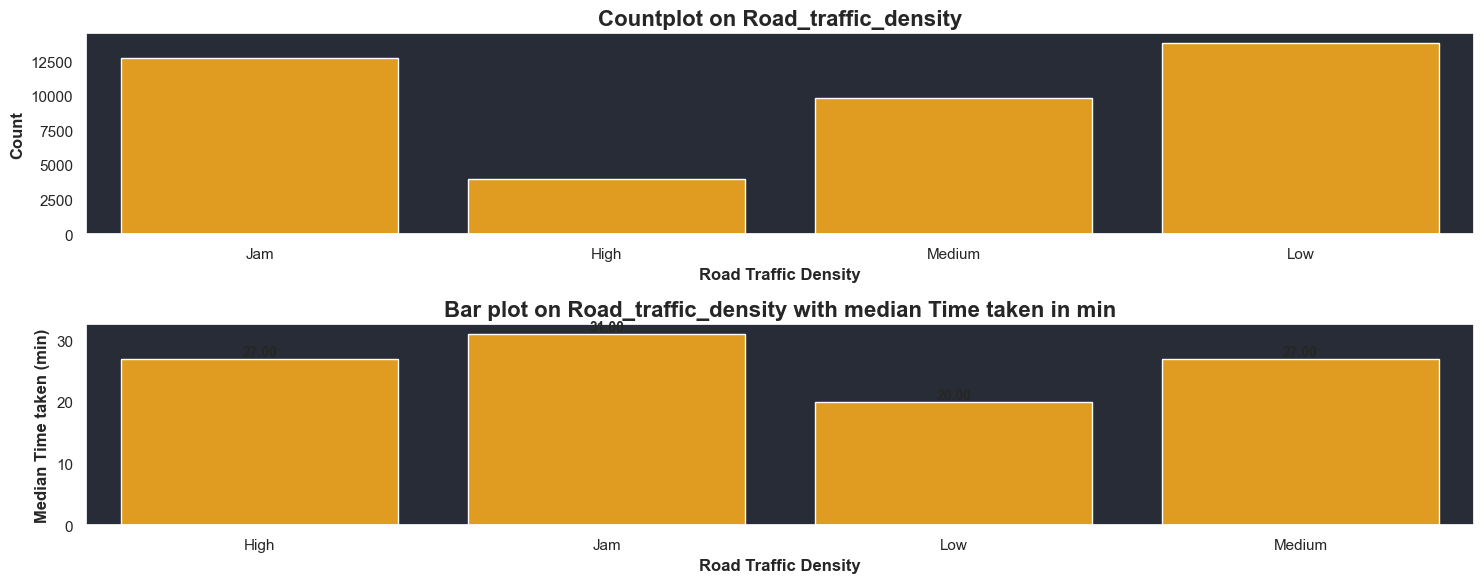

In [35]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a figure with subplots arranged in a row
plt.figure(figsize=(15, 6))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Subplot 1: Countplot of Road traffic density
plt.subplot(2, 1, 1)
sns.countplot(x="Road_traffic_density", data=df, palette=["orange"])
plt.title("Countplot on Road_traffic_density", fontproperties=font_title)
plt.xlabel('Road Traffic Density', fontproperties=font_bold)
plt.ylabel('Count', fontproperties=font_bold)

# Subplot 2: Bar plot of median Time_taken (min) w.r.t Road traffic density
plt.subplot(2, 1, 2)
data2 = df.groupby(['Road_traffic_density'])['Time_taken (min)'].median().reset_index()
ax2 = sns.barplot(x='Road_traffic_density', y='Time_taken (min)', data=data2, errwidth=0, palette=["orange"])
plt.title('Bar plot on Road_traffic_density with median Time taken in min', fontproperties=font_title)
plt.xlabel('Road Traffic Density', fontproperties=font_bold)
plt.ylabel('Median Time taken (min)', fontproperties=font_bold)

# Add labels to the bar plot
for bar in ax2.patches:
    ax2.annotate(format(bar.get_height(), '.2f'), 
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 ha='center', va='center', size=10, fontproperties=font_bold,
                 xytext=(0, 5), textcoords='offset points')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


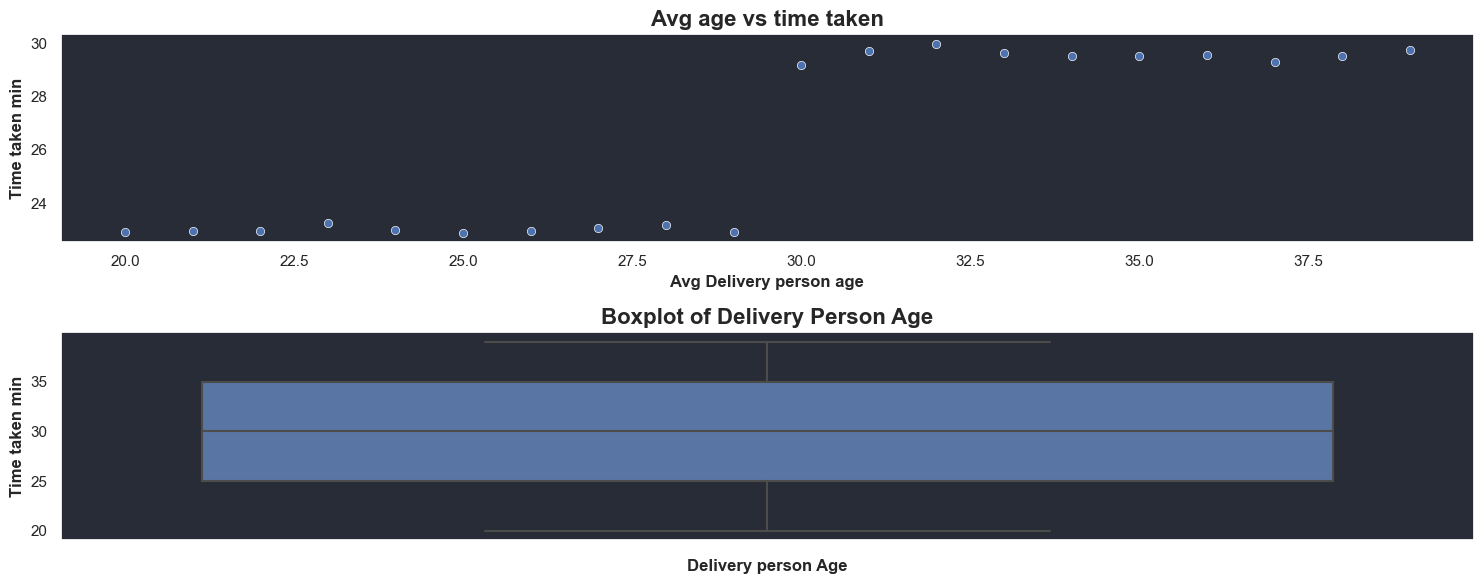

In [36]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a figure with subplots arranged in a row
plt.figure(figsize=(15, 6))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Subplot 1: Scatterplot of Avg Delivery person age vs Time taken
plt.subplot(2, 1, 1)
data1 = df.groupby(['Delivery_person_Age'])['Time_taken (min)'].mean().reset_index()
sns.scatterplot(x='Delivery_person_Age', y='Time_taken (min)', data=data1)
plt.xlabel('Avg Delivery person age', fontproperties=font_bold)
plt.ylabel("Time taken min", fontproperties=font_bold)
plt.title('Avg age vs time taken', fontproperties=font_title)

# Subplot 2: Boxplot of Delivery_person_Age
plt.subplot(2, 1, 2)
sns.boxplot(y=df['Delivery_person_Age'])
plt.xlabel('Delivery person Age', fontproperties=font_bold)
plt.ylabel("Time taken min", fontproperties=font_bold)
plt.title('Boxplot of Delivery Person Age', fontproperties=font_title)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


In [37]:
# as the age is increses the time of delivery is also inc.

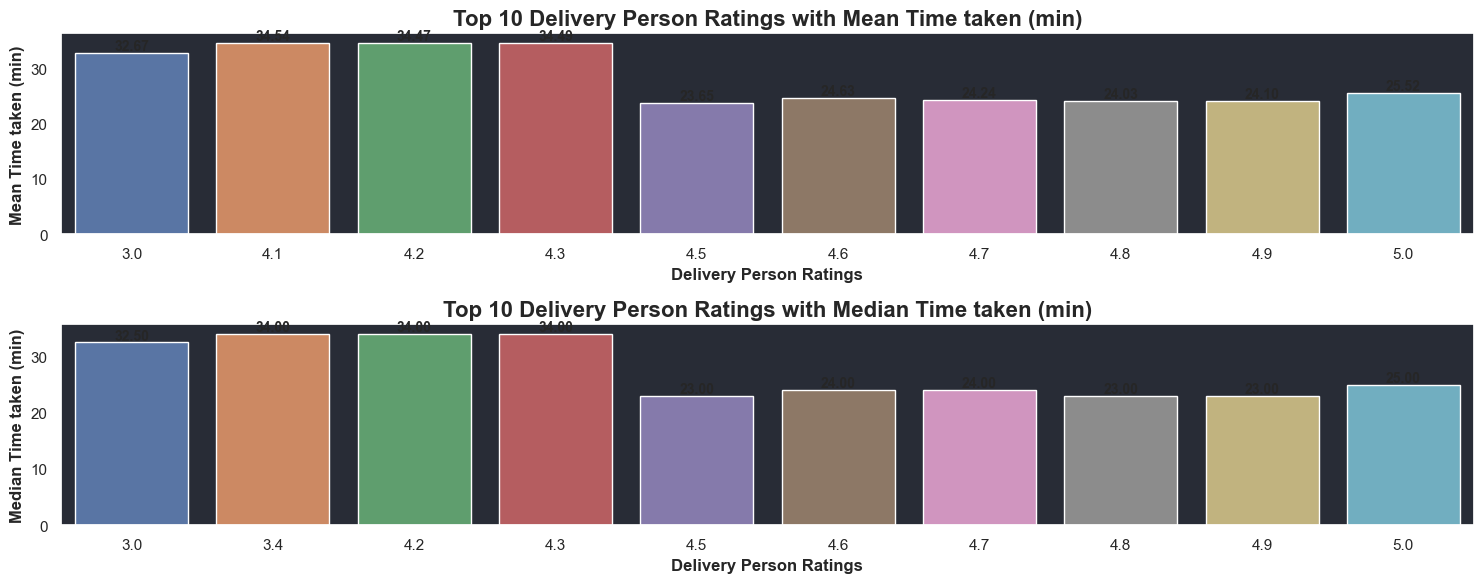

In [38]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})
plt.figure(figsize=(15, 6))


data1 = df.groupby(['Delivery_person_Ratings'])['Time_taken (min)'].mean().reset_index()
data1.sort_values('Time_taken (min)', inplace=True)

plt.subplot(2, 1, 1)
ax1 = sns.barplot(data=data1.head(10), x='Delivery_person_Ratings', y='Time_taken (min)')
plt.title('Top 10 Delivery Person Ratings with Mean Time taken (min)', fontproperties=font_title)
plt.xlabel('Delivery Person Ratings', fontproperties=font_bold)
plt.ylabel('Mean Time taken (min)', fontproperties=font_bold)

data2 = df.groupby(['Delivery_person_Ratings'])['Time_taken (min)'].median().reset_index()
data2.sort_values('Time_taken (min)', inplace=True)
plt.subplot(2, 1, 2)
ax2 = sns.barplot(data=data2.head(10), x='Delivery_person_Ratings', y='Time_taken (min)')
plt.title('Top 10 Delivery Person Ratings with Median Time taken (min)', fontproperties=font_title)
plt.xlabel('Delivery Person Ratings', fontproperties=font_bold)
plt.ylabel('Median Time taken (min)', fontproperties=font_bold)

# Add labels to the bar plots
for ax in [ax1, ax2]:
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                    ha='center', va='center', size=10, fontproperties=font_bold,
                    xytext=(0, 5), textcoords='offset points')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


**Observations:**
1. Person with lower rating is taking more time

##### **Multivariate Analysis**

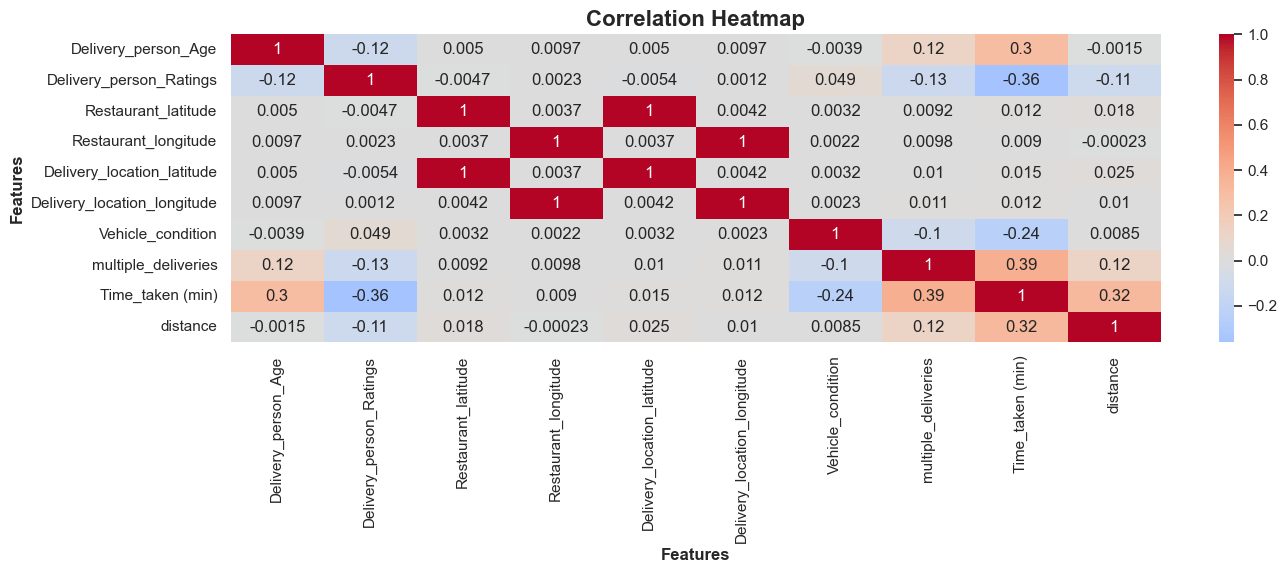

In [39]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Select numerical features
num_features = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr_matrix = num_features.corr()

# Create a figure and set the size
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the correlation heatmap using Seaborn
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)

# Set the title and axis labels
plt.title("Correlation Heatmap", fontproperties=font_title)
plt.xlabel('Features', fontproperties=font_bold)
plt.ylabel('Features', fontproperties=font_bold)

# Display the heatmap
plt.show()


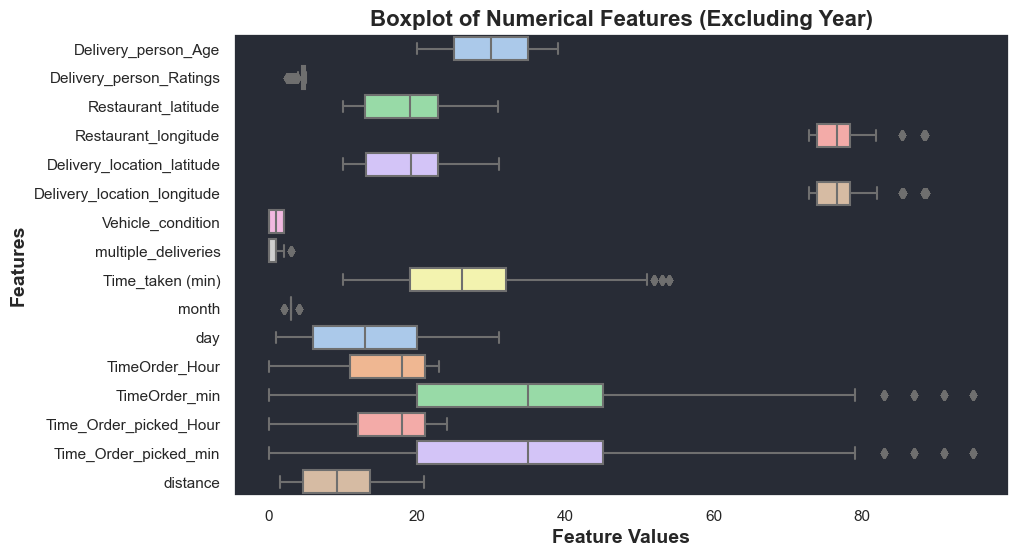

In [40]:
# Remove the "year" column from the DataFrame
df_without_year = df.drop(columns=["year"])

# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a custom color palette
custom_palette = sns.color_palette("pastel")

# Create a boxplot using Seaborn with the custom palette
plt.figure(figsize=(10, 6))
font_bold = {'fontsize': 14, 'fontweight': 'bold'}
font_title = {'fontsize': 16, 'fontweight': 'bold'}

# Create the plot with custom palette
boxplot = sns.boxplot(data=df_without_year, orient="h", palette=custom_palette)

# Set title and labels
plt.title('Boxplot of Numerical Features (Excluding Year)', fontdict=font_title)
plt.xlabel('Feature Values', fontdict=font_bold)
plt.ylabel('Features', fontdict=font_bold)

# Show the plot
plt.show()


**Observations:**
1. Outliers are present in few columns

In [41]:
df[df['Road_traffic_density']=='Low']

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weather_conditions,...,Time_taken (min),year,month,day,TimeOrder_Hour,TimeOrder_min,Time_Order_picked_Hour,Time_Order_picked_min,Delivery_city,distance
3,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,09:20,09:30,Sandstorms,...,20,2022,2,13,9,20,9,30,LUDH,2.930258
11,RANCHIRES06DEL02,31.0,4.7,23.357804,85.325146,23.487804,85.455146,22:30,22:45,Sandstorms,...,26,2022,3,10,22,30,22,45,RANCHI,19.618739
12,COIMBRES13DEL01,37.0,5.0,11.003669,76.976494,11.013669,76.986494,08:15,08:30,Sandstorms,...,20,2022,3,11,8,15,8,30,COIMB,1.558132
17,SURRES15DEL03,35.0,4.3,21.160522,72.771477,21.250522,72.861477,23:20,23:30,Cloudy,...,38,2022,3,12,23,20,23,30,SUR,13.682045
19,PUNERES04DEL01,23.0,4.8,18.514210,73.838429,18.624210,73.948429,23:35,23:45,Windy,...,12,2022,4,2,23,35,23,45,PUNE,16.853619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45569,COIMBRES03DEL02,30.0,4.9,11.025083,77.015393,11.045083,77.035393,10:25,10:40,Windy,...,26,2022,3,11,10,25,10,40,COIMB,3.116127
45571,MYSRES08DEL02,34.0,4.9,12.297954,76.665169,12.317954,76.685169,09:10,09:15,Sandstorms,...,26,2022,4,5,9,10,9,15,MYS,3.109134
45573,PUNERES13DEL02,30.0,4.6,18.562450,73.916619,18.582450,73.936619,0:37,09:15,Cloudy,...,20,2022,4,1,0,37,9,15,PUNE,3.064267
45575,CHENRES08DEL02,37.0,4.8,13.022394,80.242439,13.042394,80.262439,09:35,09:50,Sandstorms,...,20,2022,4,5,9,35,9,50,CHEN,3.104827


* This ranking is based on the potential danger and impact each condition may have on daily activities and travel. Stormy conditions can bring heavy rain, strong winds, and lightning, posing the highest risk. Sandstorms can cause respiratory problems and limit visibility, while fog and windy conditions can make driving hazardous. Cloudy conditions can indicate upcoming storms or weather changes, and sunny conditions are generally considered the least severe.

### **3. Data Pre-processing**

In [42]:
# Print the number of columns before dropping columns
print(f" Number of columns before dropping columns: {len(df.columns)}")

# Drop the 'Delivery_person_ID' column from the DataFrame
df.drop('Delivery_person_ID', axis=1, inplace=True)

# Drop the 'Time_Orderd' and 'Time_Order_picked' columns from the DataFrame
df.drop(['Time_Orderd', 'Time_Order_picked'], axis=1, inplace=True)

# Print the number of columns after dropping columns
print(f" Number of columns after dropping columns: {len(df.columns)}")


 Number of columns before dropping columns: 27
 Number of columns after dropping columns: 24


##### **Segregating numrical & categorical features analysis**

In [43]:
# Create a list of column names for numerical features
num_col = [feature for feature in df.columns if df[feature].dtypes != 'O']

# Create a list of column names for categorical features
cat_col = [feature for feature in df.columns if df[feature].dtypes == 'O']

# Print the list of numerical columns
print("Numerical Columns:", num_col)

# Print the list of categorical columns
print("Categorical Columns:", cat_col)


Numerical Columns: ['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Vehicle_condition', 'multiple_deliveries', 'Time_taken (min)', 'year', 'month', 'day', 'TimeOrder_Hour', 'TimeOrder_min', 'Time_Order_picked_Hour', 'Time_Order_picked_min', 'distance']
Categorical Columns: ['Weather_conditions', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'Festival', 'City', 'Delivery_city']


In [44]:
print("Original shape:", df.shape)
# Drop rows with missing values in 'Delivery_person_Age' and 'multiple_deliveries'
df = df.dropna(subset=['Delivery_person_Age', 'multiple_deliveries'], how='any')
# Verify the shape of the cleaned DataFrame
print("Cleaned shape:", df.shape)


Original shape: (40344, 24)
Cleaned shape: (39297, 24)


##### **Spliting Independent and Dependent Features**

In [45]:
X = df.drop(labels=['Time_taken (min)'],axis=1)
y = df[['Time_taken (min)']]

In [46]:
num_col=[feature for feature in X.columns if X[feature].dtypes != 'O']
cat_col=[feature for feature in X.columns if X[feature].dtypes == 'O']

In [47]:
# Assuming you have your numerical features stored in 'num_col'

# Calculate VIF for each feature
df_numerical = X[num_col].values
vif_data = pd.DataFrame()
vif_data["feature"] = num_col
vif_data["VIF"] = [variance_inflation_factor(df_numerical, i) for i in range(df_numerical.shape[1])]

# Display the VIF values
print("================================================================")
print(vif_data)

# Select features with VIF less than a certain threshold (e.g., 5)
selected_features = vif_data[vif_data["VIF"] < 8]["feature"]

# Display the resulting DataFrame with selected features
print("================================================================")
print(f"Selected features based on VIF: {len(selected_features)}")
print("================================================================")


                        feature           VIF
0           Delivery_person_Age  1.026822e+00
1       Delivery_person_Ratings  1.038463e+00
2           Restaurant_latitude  1.801440e+15
3          Restaurant_longitude  6.928615e+14
4    Delivery_location_latitude  1.801440e+15
5   Delivery_location_longitude  6.928615e+14
6             Vehicle_condition  1.013380e+00
7           multiple_deliveries  1.052698e+00
8                          year  9.523857e+02
9                         month  1.236633e+00
10                          day  1.138970e+00
11               TimeOrder_Hour  1.879273e+00
12                TimeOrder_min  1.263319e+00
13       Time_Order_picked_Hour  1.696558e+00
14        Time_Order_picked_min  1.614367e+00
15                     distance  3.492348e+03
Selected features based on VIF: 10


In [48]:
# # Selecting final features after deleting highly correlated variables
# # Adding distance feature thogh it has high correlation because distance is a important factor in delivery time prediction
selected_features = list(selected_features)
selected_features.append('distance')
X = X[selected_features + cat_col]

##### **Train Test Split**

In [49]:
# Split the dataset into training and testing sets
# X: The feature data
# y: The target data
# test_size: The proportion of the data to be allocated to the testing set (20% in this case)
# random_state: Seed for random number generation to ensure reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (31437, 18)
X_test shape: (7860, 18)
y_train shape: (31437, 1)
y_test shape: (7860, 1)


##### **Encoding & Scaling**

In [50]:
# Define the categorical values for Road traffic density and Weather conditions
Road_traffic_density = ['Low', 'Medium', 'High', 'Jam']
Weather_conditions = ['Sunny', 'Cloudy', 'Windy', 'Fog', 'Sandstorms', 'Stormy']

# Define lists to group different types of columns
categorical_columns = ['Type_of_order', 'Type_of_vehicle', 'Festival', 'City', 'Delivery_city']
ordinal_encod = ['Road_traffic_density', 'Weather_conditions']
numerical_columns = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition', 'multiple_deliveries',
                    'month', 'day', 'TimeOrder_Hour', 'TimeOrder_min', 'Time_Order_picked_Hour','Time_Order_picked_min',
                    'distance']

# Create a numerical pipeline for preprocessing numerical features
numerical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),  # Impute missing values with 0
    ('scaler', StandardScaler(with_mean=False))  # Scale the features using StandardScaler
])

# Create a categorical pipeline for preprocessing categorical features
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore')),  # Encode categorical features using OneHotEncoder
    ('scaler', StandardScaler(with_mean=False))  # Scale the encoded features using StandardScaler
])

# Create an ordinal pipeline for preprocessing ordinal features
ordianl_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
    ('ordinal', OrdinalEncoder(categories=[Road_traffic_density, Weather_conditions])),  # Encode ordinal features
    ('scaler', StandardScaler(with_mean=False))  # Scale the encoded features using StandardScaler
])

# Create a ColumnTransformer to apply different pipelines to different columns
preprocessor = ColumnTransformer([
    ('numerical_pipeline', numerical_pipeline, numerical_columns),
    ('categorical_pipeline', categorical_pipeline, categorical_columns),
    ('ordianl_pipeline', ordianl_pipeline, ordinal_encod)
])

# Apply the preprocessing to the training and test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Print the preprocessed training and test data
print("Preprocessed X_train:\n", X_train)
print("\nPreprocessed X_test:\n", X_test)


Preprocessed X_train:
 [[ 4.5148959  15.62384859  0.         ...  0.          2.40667226
   2.93683949]
 [ 5.55679495 14.66728643  1.22572299 ...  0.          0.
   0.5873679 ]
 [ 4.16759621 15.62384859  2.45144599 ...  0.          0.80222409
   1.7621037 ]
 ...
 [ 6.77234385 15.30499453  2.45144599 ...  0.          0.80222409
   0.        ]
 [ 5.03584543 15.62384859  1.22572299 ...  0.          2.40667226
   2.93683949]
 [ 4.16759621 15.30499453  2.45144599 ...  0.          2.40667226
   2.93683949]]

Preprocessed X_test:
 [[ 6.42504416 14.66728643  2.45144599 ...  0.          0.80222409
   0.5873679 ]
 [ 4.68854574 14.66728643  0.         ...  0.          2.40667226
   0.        ]
 [ 6.77234385 13.71072427  0.         ...  0.          1.60444818
   2.34947159]
 ...
 [ 6.59869401 13.07301616  1.22572299 ...  0.          1.60444818
   2.34947159]
 [ 3.64664669 14.34843238  0.         ...  0.          0.
   0.        ]
 [ 6.07774448 13.07301616  0.         ...  0.          2.40667226
  

### **4. Model Building**

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [52]:
def evaluate_reg(true, predicted, X_train):
    r2 = r2_score(true, predicted)  # Calculate r2 score
    n_samples, n_features = X_train.shape
    adj_r2 = 1 - ((1 - r2) * (n_samples - 1) / (n_samples - n_features - 1))  # Adjusted R-squared formula
    MAE = mean_absolute_error(true, predicted)  # Calculate MAE
    MSE = mean_squared_error(true, predicted)  # Calculate MSE
    rmse = np.sqrt(MSE)  # Calculate RMSE
    
    return r2, adj_r2, MAE, MSE, rmse


##### **Base Model**

In [53]:
# We will train the base models
base_models = {
    1: RandomForestRegressor(),
    2: LinearRegression(),
    3: GradientBoostingRegressor(),
    4: DecisionTreeRegressor(),
    5: XGBRegressor(),
    6: Lasso(),
    7: Ridge(),
    8: ElasticNet(),
    9: SVR()
}

map_keys = list(base_models.keys())

# Get model name using id from linear_model_collection
def get_model_building_technique_name(num):
  if num == 1:
    return 'RandomForestRegressor()'
  if num == 2:
    return 'LinearRegression()'
  if num == 3:
    return 'GradientBoostingRegressor()'
  if num == 4:
    return "DecisionTreeRegressor()"
  if num == 5:
    return "XGBRegressor()"
  if num == 6:
    return "Lasso()"
  if num == 7:
    return "Ridge()"
  if num == 8:
    return "ElasticNet()"
  if num == 9:
    return "SVR()"
  
  return ''

In [54]:
result_base_models = []
for key_index in range(len(map_keys)):
  key = map_keys[key_index]
  model = base_models[key]
  print(key_index)
  model.fit(X_train, y_train)

  '''Test Accuracy'''
  y_pred_test = model.predict(pd.DataFrame(X_test))

  # R_Squared_Test = r2_score(y_test,y_pred)
  # Adjusted_R_Squared_Test = (1 - (1-R_Squared_Test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
  R_Squared_Test, Adjusted_R_Squared_Test, MAE_Test, MSE_Test, RMSE_Test   = evaluate_reg(y_test,y_pred_test, X_test)


  '''Train Accuracy'''
  y_pred_train = model.predict(X_train)

  # R_Squared_Train = r2_score(y_train,y_pred_train)
  # Adjusted_R_Squared_Train = (1 - (1-R_Squared_Train)*(len(y_train)-1)/(len(y_train)-X_test.shape[1]-1))
  R_Squared_Train, Adjusted_R_Squared_Train, MAE_Train, MSE_Train, RMSE_Train   = evaluate_reg(y_train,y_pred_train, X_train)

  result_base_models.append({
      'Model Name' : get_model_building_technique_name(key),
      'Trained Model' : model,
      'R_Squared_Test' : R_Squared_Test,
      'Adjusted_R_Squared_Test' : Adjusted_R_Squared_Test,
      'MAE_Test' : MAE_Test,
      'MSE_Test' : MSE_Test,
      'RMSE_Test' : RMSE_Test,
      'R_Squared_Train' : R_Squared_Train,
      'Adjusted_R_Squared_Train' : Adjusted_R_Squared_Train,
      'MAE_Train' : MAE_Train,
      'MSE_Train' : MSE_Train,
      'RMSE_Train' : RMSE_Train
      })

0
1
2
3
4
5
6
7
8


In [55]:
result_df_base_model = pd.DataFrame(result_base_models)
result_df_base_model
     

,Model Name,Trained Model,R_Squared_Test,Adjusted_R_Squared_Test,MAE_Test,MSE_Test,RMSE_Test,R_Squared_Train,Adjusted_R_Squared_Train,MAE_Train,MSE_Train,RMSE_Train
0,RandomForestRegressor(),"(DecisionTreeRegressor(max_features=1.0, rando...",0.829785,0.828761,3.125847,15.009255,3.874178,0.976014,0.975978,1.149897,2.102697,1.450068
1,LinearRegression(),LinearRegression(),0.553917,0.551233,4.987921,39.334913,6.271755,0.544555,0.543873,5.023371,39.925367,6.318652
2,GradientBoostingRegressor(),([DecisionTreeRegressor(criterion='friedman_ms...,0.781985,0.780673,3.538204,19.224212,4.384542,0.777861,0.777528,3.538800,19.473253,4.412851
3,DecisionTreeRegressor(),DecisionTreeRegressor(),0.674636,0.672678,4.106870,28.690076,5.356312,1.000000,1.000000,0.000000,0.000000,0.000000
4,XGBRegressor(),"XGBRegressor(base_score=None, booster=None, ca...",0.830076,0.829054,3.134557,14.983628,3.870869,0.881235,0.881057,2.578765,10.411248,3.226646
5,Lasso(),Lasso(),0.482729,0.479617,5.392317,45.612144,6.753676,0.473804,0.473016,5.437459,46.127631,6.791733
6,Ridge(),Ridge(),0.554005,0.551322,4.987189,39.327078,6.271131,0.544571,0.543889,5.022916,39.924002,6.318544
7,ElasticNet(),ElasticNet(),0.478439,0.475301,5.436014,45.990400,6.781622,0.467557,0.466760,5.494668,46.675226,6.831927
8,SVR(),SVR(),0.567560,0.564958,4.872529,38.131895,6.175103,0.558477,0.557815,4.900443,38.704998,6.221334


**Observations:**
1. As the adjusted R-squared test value is not satisfactory for all of the algorithms, we should perform hyperparameter tuning.

#### **Hyperparameter Tuning**

In [56]:
# Define hyperparameters for each algorithm
rf_hyperparameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt"]
}

lr_hyperparameters = {
    "normalize": [True, False]
}

gb_hyperparameters = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}

dt_hyperparameters = {
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt"]
}

xgb_hyperparameters = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}

lasso_hyperparameters = {
    "alpha": [0.01, 0.1, 1.0]
}

ridge_hyperparameters = {
    "alpha": [0.01, 0.1, 1.0]
}

elasticnet_hyperparameters = {
    "alpha": [0.01, 0.1, 1.0],
    "l1_ratio": [0.2, 0.5, 0.8]
}

svr_hyperparameters = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf", "poly"]
}

# Create a dictionary of hyperparameters for each algorithm
tuned_models = {
    1: RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=rf_hyperparameters, n_iter=10, cv=3),
    2: LinearRegression(),
    3: RandomizedSearchCV(estimator=GradientBoostingRegressor(), param_distributions=gb_hyperparameters, n_iter=10, cv=3),
    4: RandomizedSearchCV(estimator=DecisionTreeRegressor(), param_distributions=dt_hyperparameters, n_iter=10, cv=3),
    5: RandomizedSearchCV(estimator=XGBRegressor(), param_distributions=xgb_hyperparameters, n_iter=10, cv=3),
    6: RandomizedSearchCV(estimator=Lasso(), param_distributions=lasso_hyperparameters, n_iter=10, cv=3),
    7: RandomizedSearchCV(estimator=Ridge(), param_distributions=ridge_hyperparameters, n_iter=10, cv=3),
    8: RandomizedSearchCV(estimator=ElasticNet(), param_distributions=elasticnet_hyperparameters, n_iter=10, cv=3),
    9: RandomizedSearchCV(estimator=SVR(), param_distributions=svr_hyperparameters, n_iter=10, cv=3)
}

map_keys = list(tuned_models.keys())

# Get model name using id from linear_model_collection
def get_model_building_technique_name(num):
  if num == 1:
    return 'RandomForestRegressor_Tuned()'
  if num == 2:
    return 'LinearRegression_Tuned()'
  if num == 3:
    return 'GradientBoostingRegressor_Tuned()'
  if num == 4:
    return "DecisionTreeRegressor_Tuned()"
  if num == 5:
    return "XGBRegressor_Tuned()"
  if num == 6:
    return "Lasso_Tuned()"
  if num == 7:
    return "Ridge_Tuned()"
  if num == 8:
    return "ElasticNet_Tuned()"
  if num == 9:
    return "SVR_Tuned()"
  
  return ''

In [57]:
result_tuned_models = []
for key_index in range(len(map_keys)):
  key = map_keys[key_index]
  model = tuned_models[key]
  print(key_index)
  model.fit(X_train, y_train)

  '''Test Accuracy'''
  y_pred_test = model.predict(pd.DataFrame(X_test))

  # R_Squared_Test = r2_score(y_test,y_pred)
  # Adjusted_R_Squared_Test = (1 - (1-R_Squared_Test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
  R_Squared_Test, Adjusted_R_Squared_Test, MAE_Test, MSE_Test, RMSE_Test   = evaluate_reg(y_test,y_pred_test, X_test)


  '''Train Accuracy'''
  y_pred_train = model.predict(X_train)

  # R_Squared_Train = r2_score(y_train,y_pred_train)
  # Adjusted_R_Squared_Train = (1 - (1-R_Squared_Train)*(len(y_train)-1)/(len(y_train)-X_test.shape[1]-1))
  R_Squared_Train, Adjusted_R_Squared_Train, MAE_Train, MSE_Train, RMSE_Train   = evaluate_reg(y_train,y_pred_train, X_train)

  result_tuned_models.append({
      'Model Name' : get_model_building_technique_name(key),
      'Trained Model' : model,
      'R_Squared_Test' : R_Squared_Test,
      'Adjusted_R_Squared_Test' : Adjusted_R_Squared_Test,
      'MAE_Test' : MAE_Test,
      'MSE_Test' : MSE_Test,
      'RMSE_Test' : RMSE_Test,
      'R_Squared_Train' : R_Squared_Train,
      'Adjusted_R_Squared_Train' : Adjusted_R_Squared_Train,
      'MAE_Train' : MAE_Train,
      'MSE_Train' : MSE_Train,
      'RMSE_Train' : RMSE_Train
      })

0
1
2
3
4
5
6
7
8


### **5. Model Evaluation**

In [58]:
result_df_tuned_models = pd.DataFrame(result_tuned_models)
result_df_tuned_models


,Model Name,Trained Model,R_Squared_Test,Adjusted_R_Squared_Test,MAE_Test,MSE_Test,RMSE_Test,R_Squared_Train,Adjusted_R_Squared_Train,MAE_Train,MSE_Train,RMSE_Train
0,RandomForestRegressor_Tuned(),"RandomizedSearchCV(cv=3, estimator=RandomFores...",0.762002,0.760570,3.645842,20.986317,4.581082,0.811645,0.811363,3.177103,16.511686,4.063457
1,LinearRegression_Tuned(),LinearRegression(),0.553917,0.551233,4.987921,39.334913,6.271755,0.544555,0.543873,5.023371,39.925367,6.318652
2,GradientBoostingRegressor_Tuned(),"RandomizedSearchCV(cv=3, estimator=GradientBoo...",0.838172,0.837199,3.065112,14.269687,3.777524,0.869664,0.869469,2.717971,11.425547,3.380170
3,DecisionTreeRegressor_Tuned(),"RandomizedSearchCV(cv=3, estimator=DecisionTre...",0.684496,0.682598,4.141163,27.820597,5.274523,0.762770,0.762415,3.551646,20.796144,4.560279
4,XGBRegressor_Tuned(),"RandomizedSearchCV(cv=3,\n e...",0.838276,0.837303,3.067327,14.260579,3.776318,0.865754,0.865553,2.760717,11.768281,3.430493
5,Lasso_Tuned(),"RandomizedSearchCV(cv=3, estimator=Lasso(),\n ...",0.554053,0.551370,4.986748,39.322916,6.270799,0.544521,0.543839,5.023144,39.928357,6.318889
6,Ridge_Tuned(),"RandomizedSearchCV(cv=3, estimator=Ridge(),\n ...",0.554005,0.551322,4.987189,39.327078,6.271131,0.544571,0.543889,5.022916,39.924002,6.318544
7,ElasticNet_Tuned(),"RandomizedSearchCV(cv=3, estimator=ElasticNet(...",0.554056,0.551373,4.986668,39.322607,6.270774,0.544530,0.543848,5.023149,39.927610,6.318830
8,SVR_Tuned(),"RandomizedSearchCV(cv=3, estimator=SVR(),\n ...",0.607603,0.605242,4.632046,34.600936,5.882256,0.610213,0.609629,4.551527,34.169648,5.845481


##### **Checking Best Model**

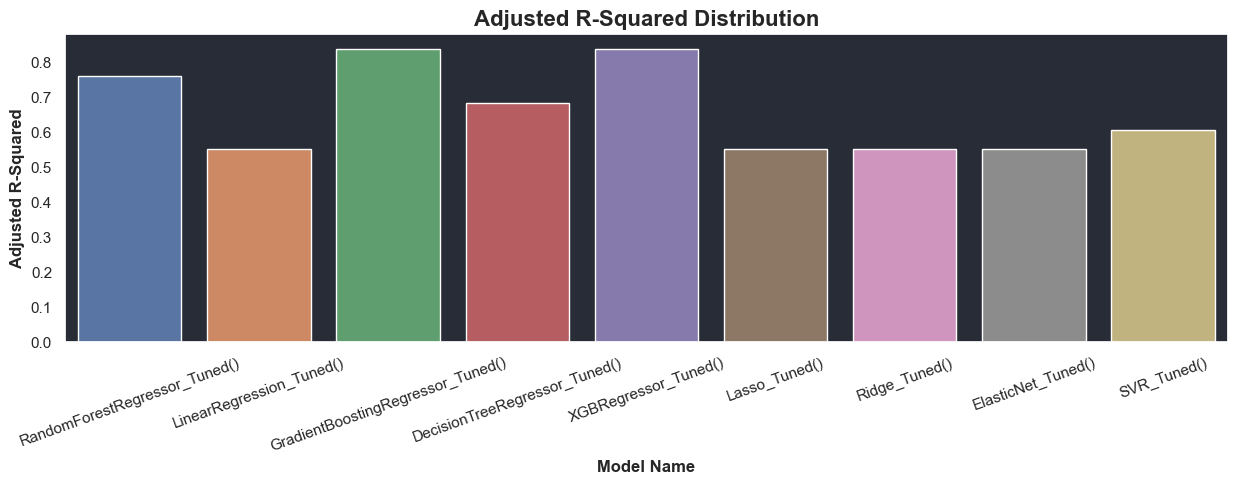

In [59]:
# Set the style for Seaborn with a black background and without grid
sns.set(style="darkgrid", rc={"axes.facecolor": "#282c36", "grid.color": "#282c36"})

# Create a count plot using Seaborn
plt.figure(figsize=(15, 4))

# Create font properties instances for bold text
font_bold = FontProperties(weight="bold")
font_title = FontProperties(size=16, weight="bold")

# Create the plot
plot = sns.barplot(data = result_df_tuned_models, x='Model Name', y='Adjusted_R_Squared_Test')
plot.set_title('Adjusted R-Squared Distribution', fontproperties=font_title)
plot.set_xlabel('Model Name', fontproperties=font_bold)
plot.set_ylabel('Adjusted R-Squared', fontproperties=font_bold)
plt.xticks(rotation = 20)

plt.show()


In [60]:

Best_Model_Name = result_df_tuned_models['Trained Model'][result_df_tuned_models[result_df_tuned_models['Adjusted_R_Squared_Test'] == max(result_df_tuned_models['Adjusted_R_Squared_Test'])]['Trained Model'].index[0]]
Best_Model_Name

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...e,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200]})

##### **Save Best Model**

In [61]:
import pickle
with open('Delivery_Time_Prediction_Model.sav', 'wb') as best_model_pickle:
    pickle.dump(Best_Model_Name, best_model_pickle)

# **<center>THE END</center>**